# Predicting Bike Rentals

## Objective

Apply decision trees and random forests to predict the total number of bikes people rented in a given hour.

## Data Set

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

[Hadi Fanaee-T](http://www.liaad.up.pt/area/fanaee) at the [University of Porto](http://www.up.pt/) compiled this data into a CSV file, The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. The data can be downloaded from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here are the descriptions for the relevant columns:

| Column     | Description                                                                                        |
|------------|----------------------------------------------------------------------------------------------------|
| instant    | A unique sequential ID number for each row                                                         |
| dteday     | The date of the rentals                                                                            |
| season     | The season in which the rentals occurred                                                           |
| yr         | The year the rentals occurred                                                                      |
| mnth       | The month the rentals occurred                                                                     |
| hr         | The hour the rentals occurred                                                                      |
| holiday    | Whether or not the day was a holiday                                                               |
| weekday    | Whether or not the day was a weekday                                                               |
| workingday | Whether or not the day was a working day                                                           |
| weathersit | The weather (as a categorical variable)                                                            |
| temp       | The temperature, on a 0-1 scale                                                                    |
| atemp      | The adjusted temperature                                                                           |
| hum        | The humidity, on a 0-1 scale                                                                       |
| windspeed  | The wind speed, on a 0-1 scale                                                                     |
| casual     | The number of casual riders (people who hadn't previously signed up with the bike sharing program) |
| registered | The number of registered riders (people who had already signed up)                                 |
| cnt        | The total number of bike rentals (casual + registered)                                             |

## Reading In the Data

In [1]:
import pandas as pd

bike_rentals = pd.read_csv("C:/Users/i7/csv/bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [2]:
bike_rentals.shape

(17379, 17)

In [3]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


(array([ 6972.,  3705.,  2659.,  1660.,   987.,   663.,   369.,   188.,
          139.,    37.]),
 array([   1. ,   98.6,  196.2,  293.8,  391.4,  489. ,  586.6,  684.2,
         781.8,  879.4,  977. ]),
 <a list of 10 Patch objects>)

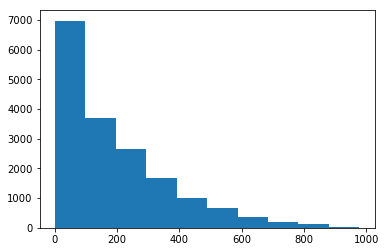

In [4]:
# take a look at the distribution of total rentals.
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(bike_rentals["cnt"])

In [5]:
# explore how each column is correlated with cnt.
import numpy as np
corr = bike_rentals.corr()["cnt"]
corr[np.argsort(corr, axis=0)[::-1]]

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

## Calculating Features

In [6]:
def assign_label(hour):
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3

bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

## Error Metric

The mean squared error metric makes the most sense to evaluate the error. MSE works on continuous numeric data, which fits the data quite well.

In [7]:
#Splitting The Data Into Train And Test Sets
train = bike_rentals.sample(frac=.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Applying Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression

predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")

reg = LinearRegression()

reg.fit(train[predictors], train["cnt"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
predictions = reg.predict(test[predictors])

error = np.mean((predictions - test["cnt"]) ** 2)
error

17836.400201888264

##### The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

## Applying Decision Trees

In [10]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(min_samples_leaf=5)

reg.fit(train[predictors], train["cnt"])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [11]:
predictions = reg.predict(test[predictors])

dt_error = np.mean((predictions - test["cnt"]) ** 2)
dt_error

2508.6556918304545

In [12]:
reg = DecisionTreeRegressor(min_samples_leaf=2)

reg.fit(train[predictors], train["cnt"])

predictions = reg.predict(test[predictors])

dt_error_2 = np.mean((predictions - test["cnt"]) ** 2)
dt_error_2

3076.335371116228

##### By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

## Applying Random Forests

In [13]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(min_samples_leaf=5)
reg.fit(train[predictors], train["cnt"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [14]:
predictions = reg.predict(test[predictors])

rf_error = np.mean((predictions - test["cnt"]) ** 2)
rf_error

2023.5035060560476

##### By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.